1. 对数据做数据探索分析（可参考EDA_BikeSharing.ipynb，不计分）
2. 适当的特征工程（可参考FE_BikeSharing.ipynb，不计分）
3. 对全体数据，随机选择其中80%做训练数据，剩下20%为测试数据，评价指标为RMSE。（10分）
4. 用训练数据训练最小二乘线性回归模型（20分）、岭回归模型、Lasso模型，其中岭回归模型（30分）和Lasso模型（30分），注意岭回归模型和Lasso模型的正则超参数调优。
5. 比较用上述三种模型得到的各特征的系数，以及各模型在测试集上的性能。并简单说明原因。（10分） 

### 字段说明
Instant记录号
Dteday：日期
Season：季节（1=春天、2=夏天、3=秋天、4=冬天）
yr：年份，(0: 2011, 1:2012)
mnth：月份( 1 to 12)
hr：小时 (0 to 23)  （只在hour.csv有，作业忽略此字段）
holiday：是否是节假日
weekday：星期中的哪天，取值为0～6
workingday：是否工作日
1=工作日 （是否为工作日，1为工作日，0为非周末或节假日
weathersit：天气（1：晴天，多云 2：雾天，阴天 3：小雪，小雨 4：大雨，大雪，大雾）
temp：气温摄氏度
atemp：体感温度
hum：湿度
windspeed：风速
casual：非注册用户个数
registered：注册用户个数
cnt：给定日期（天）时间（每小时）总租车人数，响应变量y （cnt = casual + registered）

casual、registered和cnt三个特征均为要预测的y，作业里只需对cnt进行预测

# 1. 对数据做数据探索分析

In [1]:
# 数据读取及基本处理
import pandas as pd
import numpy as np

# 作图工具包
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline

# 设置参数
params = {
    'legend.fontsize':'x-large',  # 图中解释
    'figure.figsize':(30, 10),
    'axes.labelsize':'x-large',
    'axes.titlesize':'x-large',
    'xtick.labelsize':'x-large',
    'ytick.labelsize':'x-large'
}

sn.set_style('whitegrid')
sn.set_context('talk')

plt.rcParams.update(params)
pd.options.display.max_colwidth = 600

# pandas display data frames as tables
from IPython.display import display, HTML

In [3]:
# 读入数据
train = pd.read_csv('day.csv')
print('train:'+str(train.shape))
train.head()

train:(731, 16)


instant      dteday  season  yr  mnth  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1        0        6           0   
1        2  2011-01-02       1   0     1        0        0           0   
2        3  2011-01-03       1   0     1        0        1           1   
3        4  2011-01-04       1   0     1        0        2           1   
4        5  2011-01-05       1   0     1        0        3           1   

   weathersit      temp     atemp       hum  windspeed  casual  registered  \
0           2  0.344167  0.363625  0.805833   0.160446     331         654   
1           2  0.363478  0.353739  0.696087   0.248539     131         670   
2           1  0.196364  0.189405  0.437273   0.248309     120        1229   
3           1  0.200000  0.212122  0.590435   0.160296     108        1454   
4           1  0.226957  0.229270  0.436957   0.186900      82        1518   

    cnt  
0   985  
1   801  
2  1349  
3  1562  
4  1600

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
instant       731 non-null int64
dteday        731 non-null object
season        731 non-null int64
yr            731 non-null int64
mnth          731 non-null int64
holiday       731 non-null int64
weekday       731 non-null int64
workingday    731 non-null int64
weathersit    731 non-null int64
temp          731 non-null float64
atemp         731 non-null float64
hum           731 non-null float64
windspeed     731 non-null float64
casual        731 non-null int64
registered    731 non-null int64
cnt           731 non-null int64
dtypes: float64(4), int64(11), object(1)
memory usage: 91.5+ KB


In [5]:
# 对数据值型特征，用常用统计量观察其分布
train.describe()

instant      season          yr        mnth     holiday     weekday  \
count  731.000000  731.000000  731.000000  731.000000  731.000000  731.000000   
mean   366.000000    2.496580    0.500684    6.519836    0.028728    2.997264   
std    211.165812    1.110807    0.500342    3.451913    0.167155    2.004787   
min      1.000000    1.000000    0.000000    1.000000    0.000000    0.000000   
25%    183.500000    2.000000    0.000000    4.000000    0.000000    1.000000   
50%    366.000000    3.000000    1.000000    7.000000    0.000000    3.000000   
75%    548.500000    3.000000    1.000000   10.000000    0.000000    5.000000   
max    731.000000    4.000000    1.000000   12.000000    1.000000    6.000000   

       workingday  weathersit        temp       atemp         hum   windspeed  \
count  731.000000  731.000000  731.000000  731.000000  731.000000  731.000000   
mean     0.683995    1.395349    0.495385    0.474354    0.627894    0.190486   
std      0.465233    0.544894    0.183051    0.162961    0.142429    0.077498   
min      0.000000    1.000000    0.059130    0.079070    0.000000    0.022392   
25%      0.000000    1.000000    0.337083    0.337842    0.520000    0.134950   
50%      1.000000    1.000000    0.498333    0.486733    0.626667    0.180975   
75%      1.000000    2.000000    0.655417    0.608602    0.730209    0.233214   
max      1.000000    3.000000    0.861667    0.840896    0.972500    0.507463   

            casual   registered          cnt  
count   731.000000   731.000000   731.000000  
mean    848.176471  3656.172367  4504.348837  
std     686.622488  1560.256377  1937.211452  
min       2.000000    20.000000    22.000000  
25%     315.500000  2497.000000  3152.000000  
50%     713.000000  3662.000000  4548.000000  
75%    1096.000000  4776.500000  5956.000000  
max    3410.000000  6946.000000  8714.000000

In [6]:
# 离散特征的分布
# 对类别型特征，观察其取值范围及直方图
categorical_features = ['season','mnth','weathersit','weekday']
for col in categorical_features:
    print('\n%s属性的不同取值和出现的次数'%col)
    print(train[col].value_counts())
    train[col] = train[col].astype('object')


season属性的不同取值和出现的次数
3    188
2    184
1    181
4    178
Name: season, dtype: int64

mnth属性的不同取值和出现的次数
12    62
10    62
8     62
7     62
5     62
3     62
1     62
11    60
9     60
6     60
4     60
2     57
Name: mnth, dtype: int64

weathersit属性的不同取值和出现的次数
1    463
2    247
3     21
Name: weathersit, dtype: int64

weekday属性的不同取值和出现的次数
6    105
1    105
0    105
5    104
4    104
3    104
2    104
Name: weekday, dtype: int64


类别型特征的取值不多，类别型特征可以采用独热编码（One hot encoding）/哑编码

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E334CED940>,
      dtype=object)

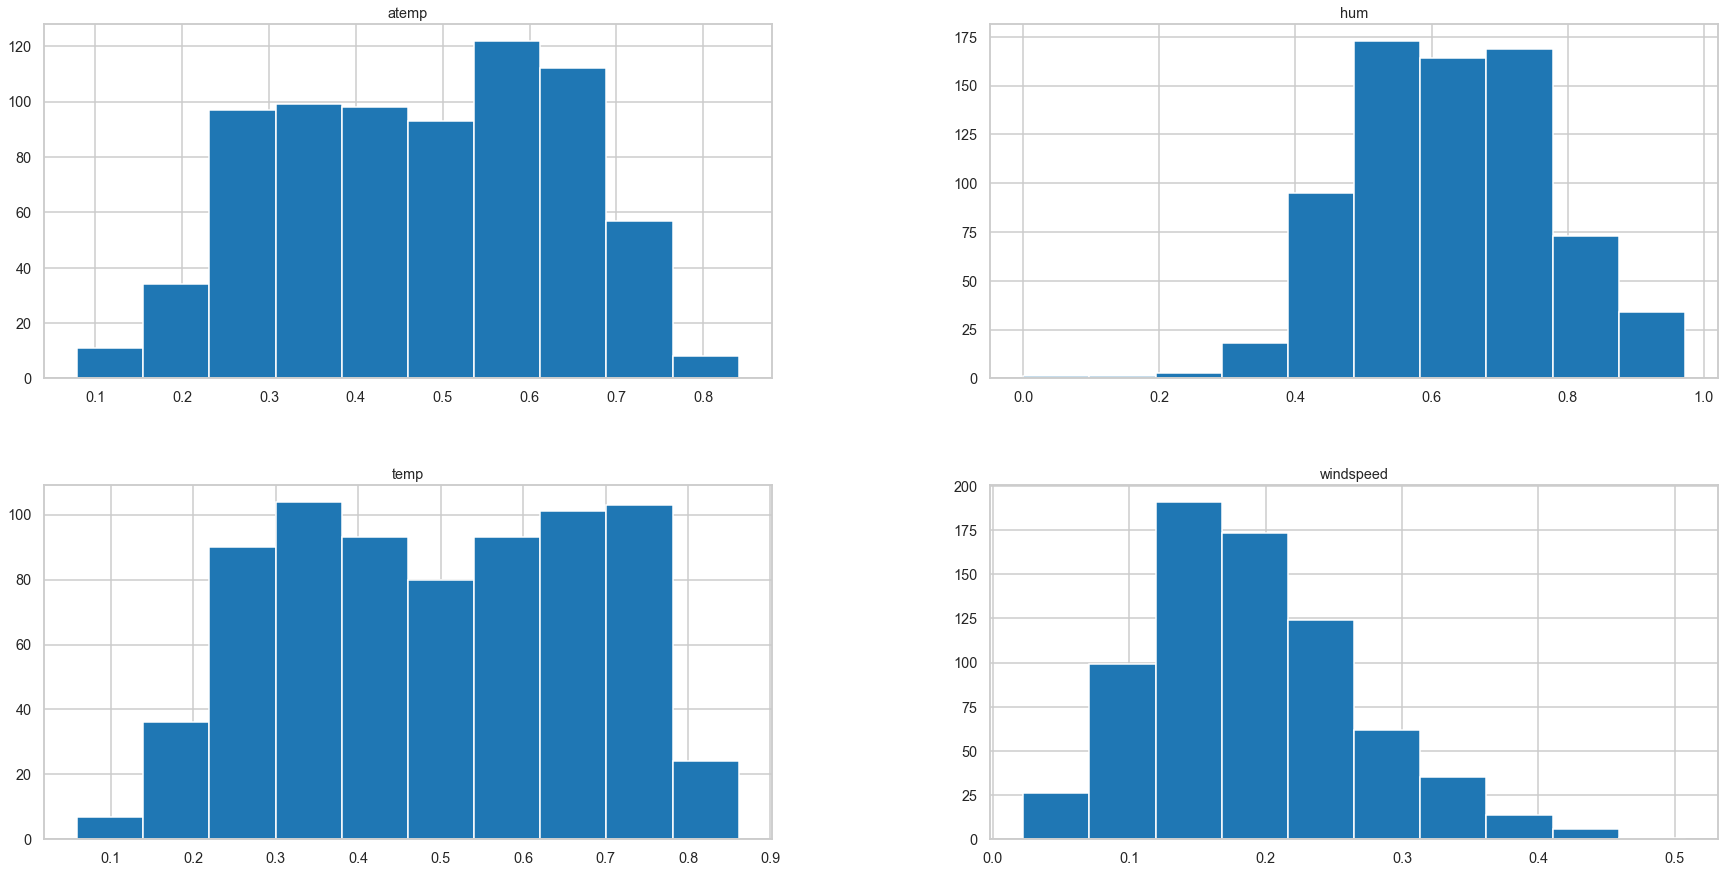

In [16]:
# 数值特征的分布
# 对数值型特征，直方图
numerical_features = ['temp', 'atemp', 'hum', 'windspeed']
train[numerical_features].hist(figsize=(30,15))

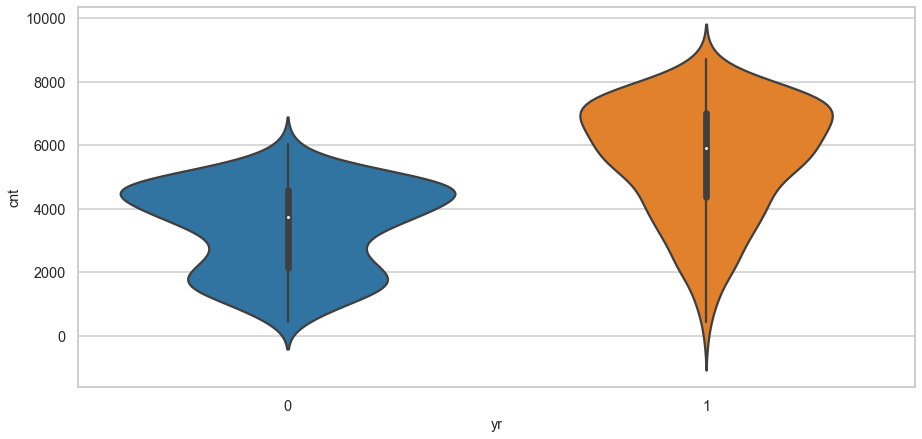

In [40]:
# 特征与目标之间的关系
# 每年骑行量的分布
# violinplot中用x表示类别（年）信息
fig, ax = plt.subplots(figsize=(15,7))
sn.violinplot(data=train[
    ['yr','cnt']],
    x = 'yr',
    y = 'cnt',
)

2011年和2012年的分布差异很大

[Text(0.5, 1.0, 'dayly distribution of counts')]

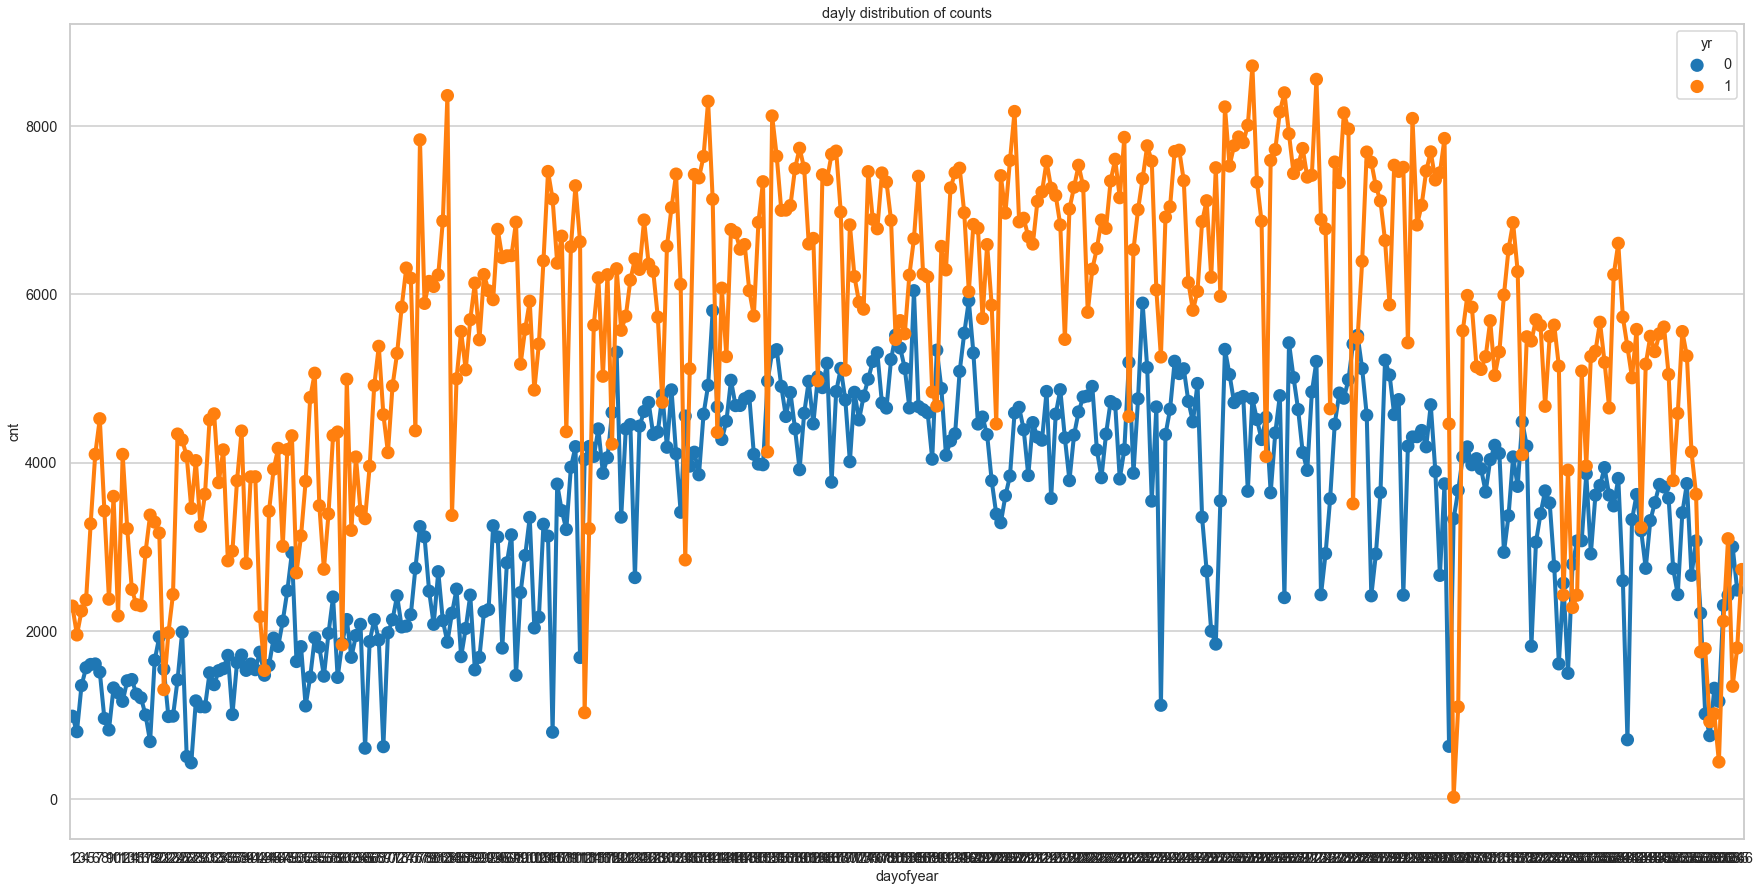

In [33]:
# 一年中每天的骑行量
# 用颜色参数hue表示类别（年）信息
import datetime

train['date'] = pd.to_datetime(train['dteday'])
train['dayofyear'] = train['date'].dt.dayofyear  # 今年的第几天

fig, ax = plt.subplots(figsize=(30,15))
sn.pointplot(data=train[['dayofyear',
                        'cnt',
                        'yr']],
            x='dayofyear',
            y='cnt',
            hue='yr',
            ax=ax)
ax.set(title='dayly distribution of counts')

每年开始和结束的数量少，中间多，骑行量和季节/月份有关

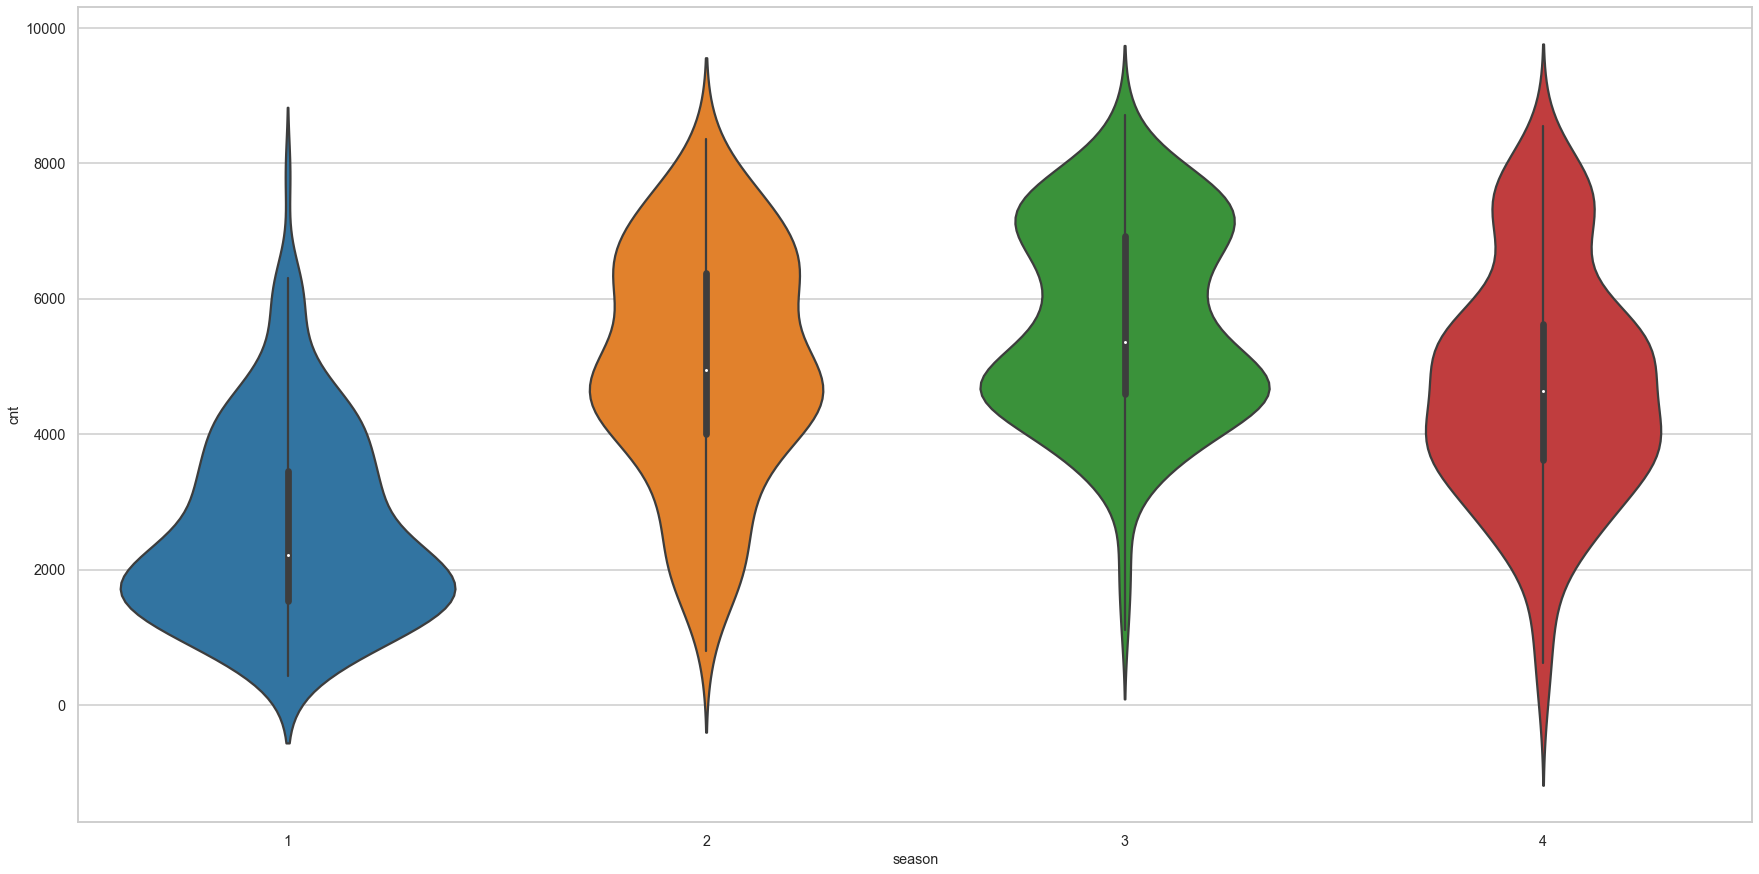

In [39]:
# 季节与骑行数量的关系
# violinplot得到详细分布
fig, ax = plt.subplots(figsize=(30,15))
sn.violinplot(data=train[['season',
                         'cnt']],
             x='season',y='cnt')

能看出来每个季节骑行量的分布不同barplot利用矩阵条的高度反映数值变量的集中趋势，以及使用errorbar功能（差棒图）来估计变量之间的差值统计。谨记barplot展示的是某种变量分布的平均值

[Text(0.5, 1.0, 'Seasonly distribution of counts')]

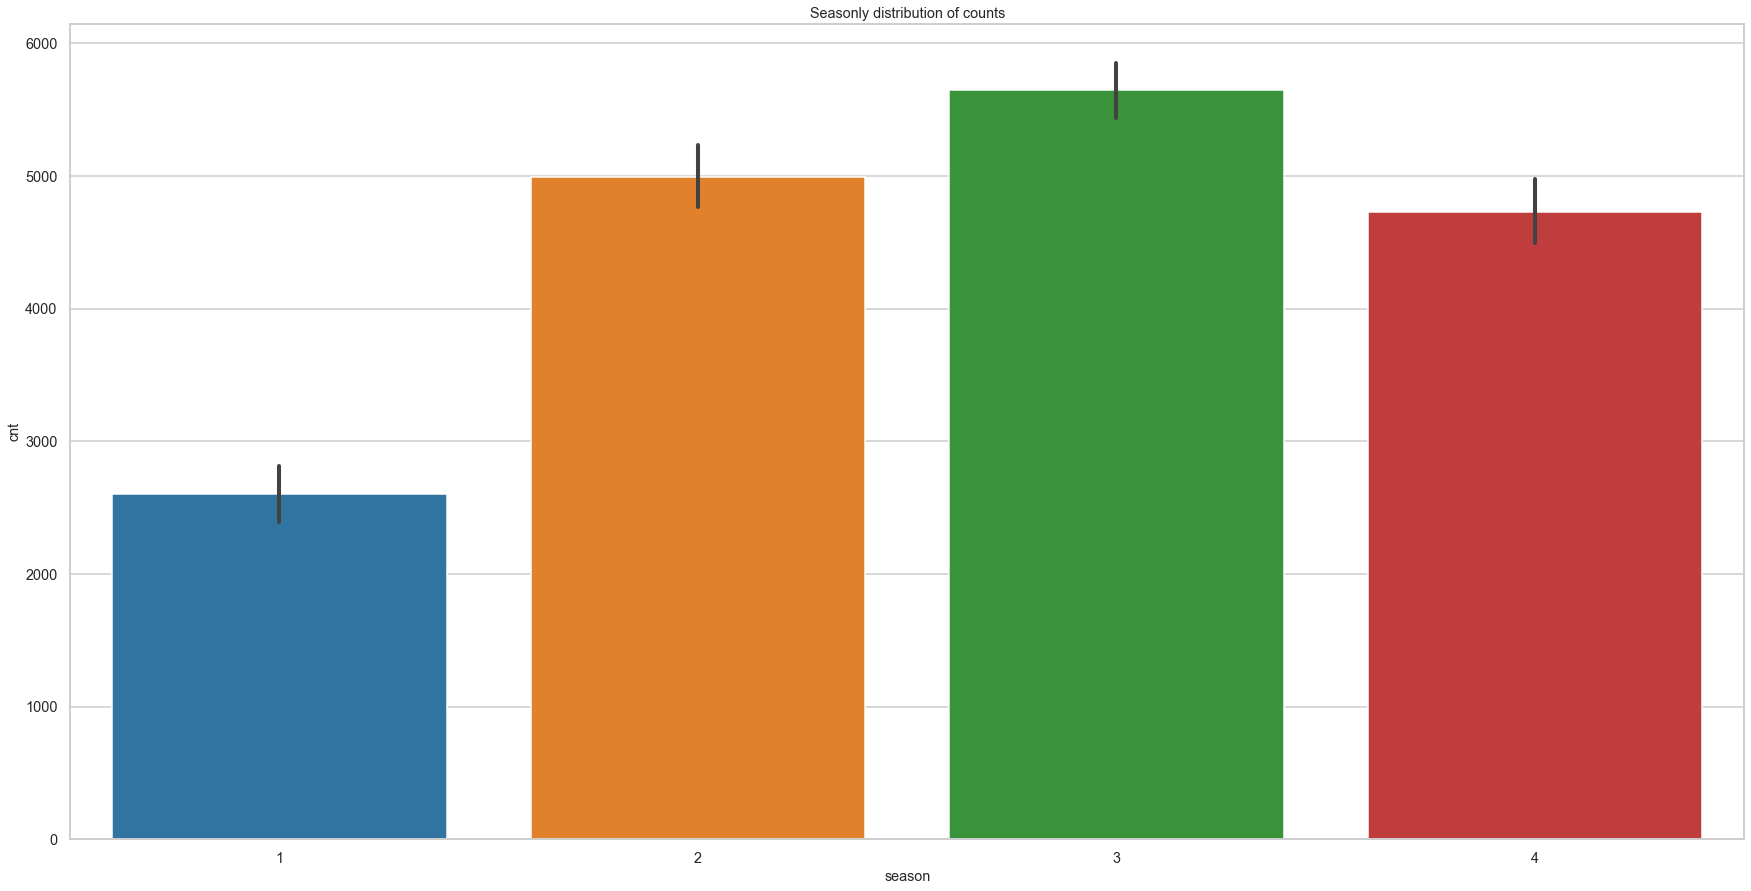

In [41]:
fig, ax = plt.subplots(figsize=(30,15))
sn.barplot(data=train[['season',
                      'cnt']],
          x='season',y='cnt')
ax.set(title='Seasonly distribution of counts')

可以看出，骑行量和季节的关系非常明显

[Text(0.5, 1.0, 'Monthly distribution of counts')]

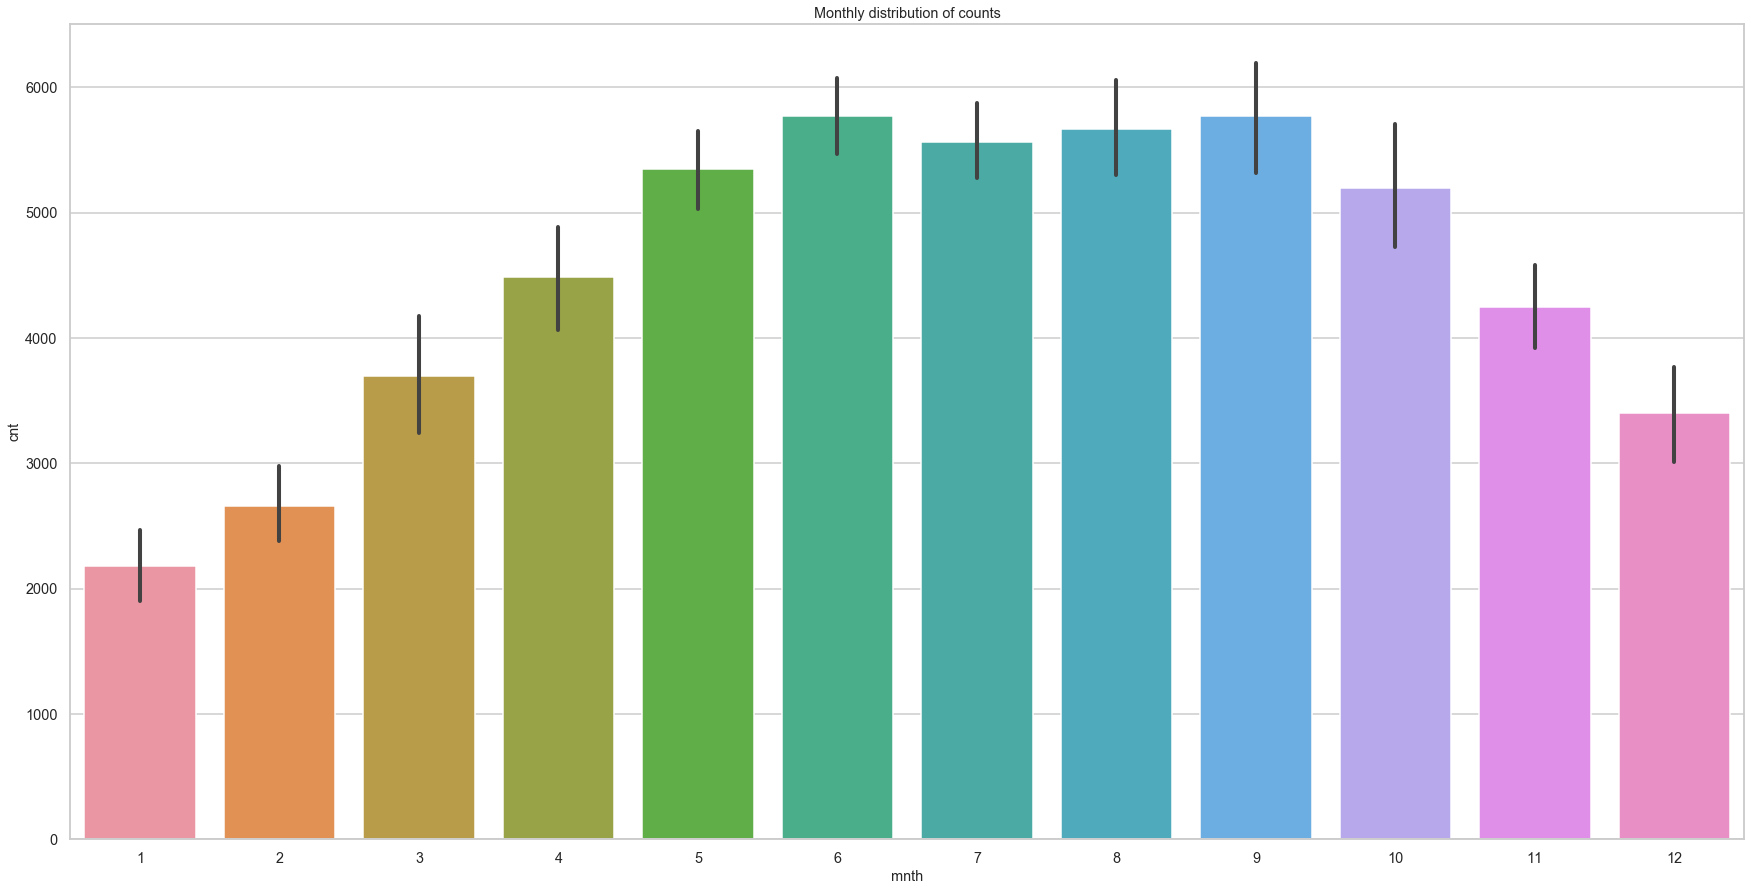

In [42]:
# 月份与骑行量的关系
fig, ax = plt.subplots(figsize=(30,15))
sn.barplot(data=train[['mnth',
                      'cnt']],
          x='mnth',y='cnt')
ax.set(title='Monthly distribution of counts')

[Text(0.5, 1.0, 'Weathersit distribution of counts')]

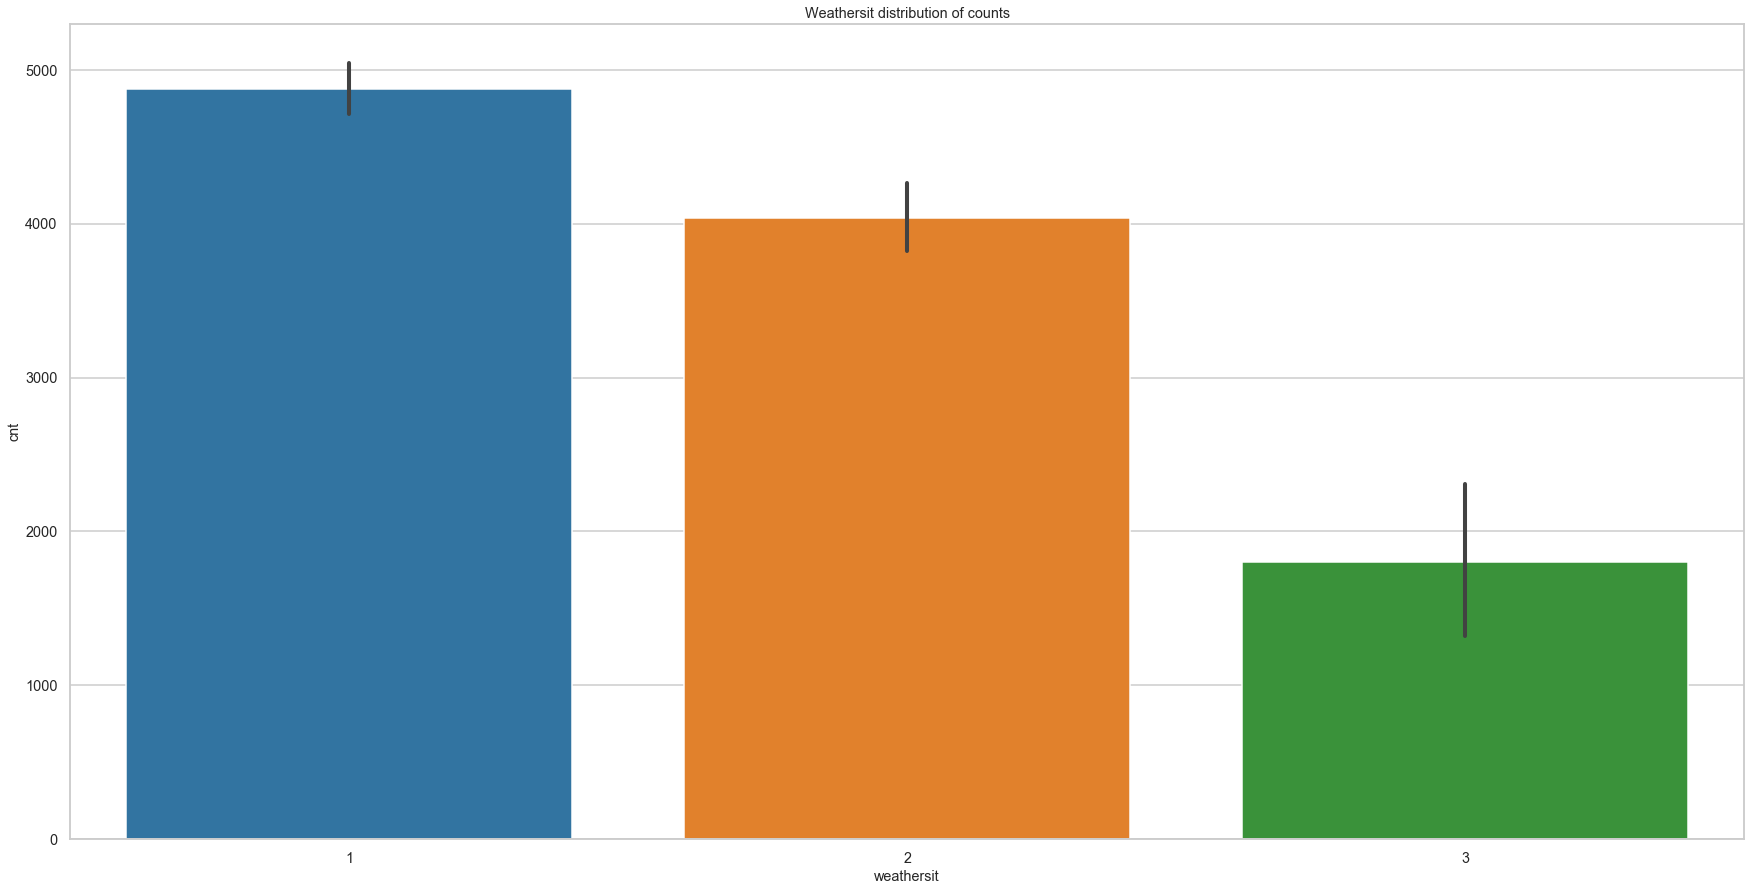

In [44]:
# 天气与骑行数量的关系
fig, ax = plt.subplots(figsize=(30,15))
sn.barplot(data=train[['weathersit',
                      'cnt']],
          x='weathersit',y='cnt')
ax.set(title='Weathersit distribution of counts')

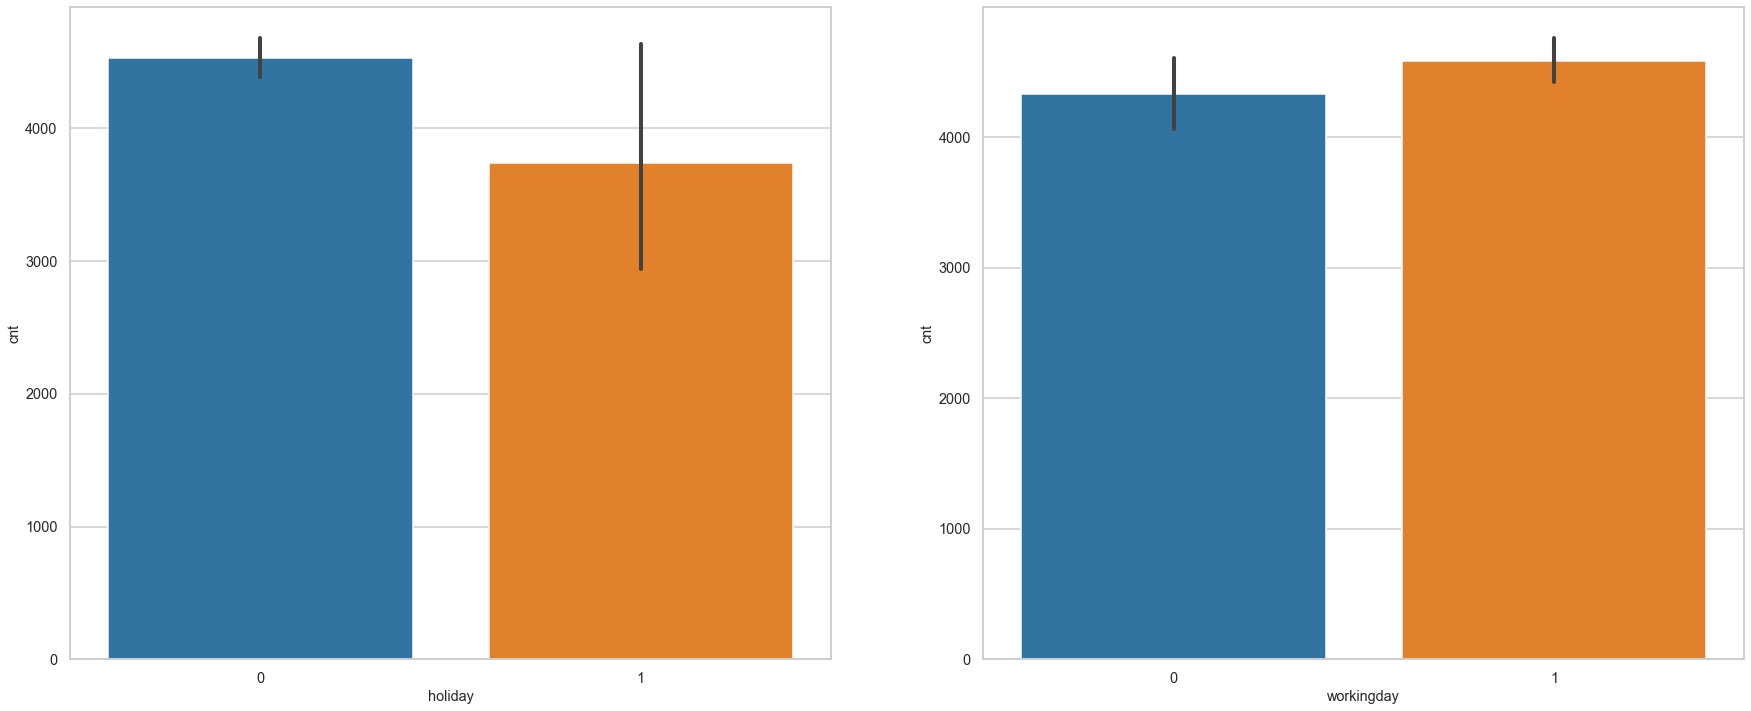

In [47]:
# 工作日和节假日的分布
fig, (ax1, ax2) = plt.subplots(figsize=(30,12), ncols=2)
sn.barplot(data=train[['holiday','cnt']], x = 'holiday', y='cnt',ax=ax1)
sn.barplot(data=train,x='workingday',y='cnt',ax=ax2)

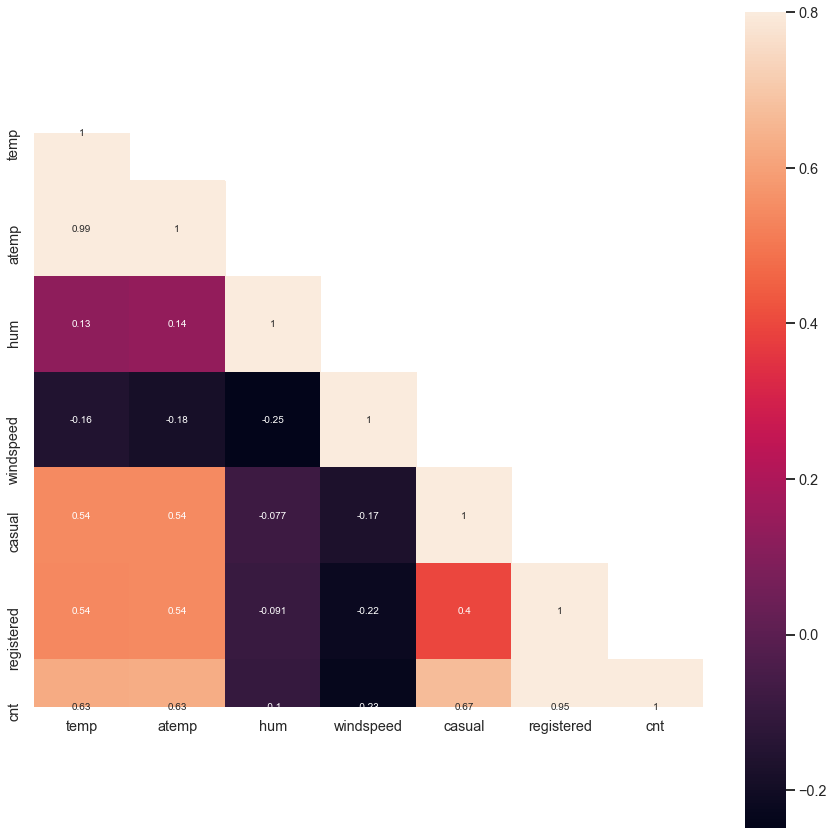

In [59]:
# 数值型特征和y之间的相关性
fig, ax = plt.subplots(figsize=(15,15))
corrMatt = train[['temp','atemp',
                 'hum','windspeed',
                 'casual','registered',
                 'cnt']].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)]=False
sn.heatmap(corrMatt, mask=mask,vmax=.8, square=True, annot=True)

体感温度和温度高度相关；目标cnt与温度正相关，与湿度和风速负相关

# 2. 适当的特征工程

### 特征工程

In [60]:
# 对类别型特征进行独热编码
# 对类别型特征，观察其取值范围及直方图
categorical_features = ['season', 'mnth', 'weathersit', 'weekday']

# 数据类型变为object，才能被get_dummies处理，独热编码
for col in categorical_features:
    train[col] = train[col].astype('object')
    
X_train_cat = train[categorical_features]
X_train_cat = pd.get_dummies(X_train_cat)
X_train_cat.head()


season_1  season_2  season_3  season_4  mnth_1  mnth_2  mnth_3  mnth_4  \
0         1         0         0         0       1       0       0       0   
1         1         0         0         0       1       0       0       0   
2         1         0         0         0       1       0       0       0   
3         1         0         0         0       1       0       0       0   
4         1         0         0         0       1       0       0       0   

   mnth_5  mnth_6  ...  weathersit_1  weathersit_2  weathersit_3  weekday_0  \
0       0       0  ...             0             1             0          0   
1       0       0  ...             0             1             0          1   
2       0       0  ...             1             0             0          0   
3       0       0  ...             1             0             0          0   
4       0       0  ...             1             0             0          0   

   weekday_1  weekday_2  weekday_3  weekday_4  weekday_5  weekday_6  
0          0          0          0          0          0          1  
1          0          0          0          0          0          0  
2          1          0          0          0          0          0  
3          0          1          0          0          0          0  
4          0          0          1          0          0          0  

[5 rows x 26 columns]

In [62]:
# 对数值型特征进行标准化/MinMaxScaler，去量纲

# 数值型变量预处理
# 使用MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
mn_X = MinMaxScaler()
numerical_features = ['temp','atemp','hum','windspeed']
temp = mn_X.fit_transform(train[numerical_features])

X_train_num = pd.DataFrame(data=temp, columns=numerical_features, index=train.index)
X_train_num.head()

temp     atemp       hum  windspeed
0  0.355170  0.373517  0.828620   0.284606
1  0.379232  0.360541  0.715771   0.466215
2  0.171000  0.144830  0.449638   0.465740
3  0.175530  0.174649  0.607131   0.284297
4  0.209120  0.197158  0.449313   0.339143

In [63]:
# 将类别型特征和数值型特征连在一起
X_train = pd.concat([X_train_cat,X_train_num, train['holiday'], train['workingday']], axis = 1, ignore_index=False)
X_train.head()

season_1  season_2  season_3  season_4  mnth_1  mnth_2  mnth_3  mnth_4  \
0         1         0         0         0       1       0       0       0   
1         1         0         0         0       1       0       0       0   
2         1         0         0         0       1       0       0       0   
3         1         0         0         0       1       0       0       0   
4         1         0         0         0       1       0       0       0   

   mnth_5  mnth_6  ...  weekday_3  weekday_4  weekday_5  weekday_6      temp  \
0       0       0  ...          0          0          0          1  0.355170   
1       0       0  ...          0          0          0          0  0.379232   
2       0       0  ...          0          0          0          0  0.171000   
3       0       0  ...          0          0          0          0  0.175530   
4       0       0  ...          1          0          0          0  0.209120   

      atemp       hum  windspeed  holiday  workingday  
0  0.373517  0.828620   0.284606        0           0  
1  0.360541  0.715771   0.466215        0           0  
2  0.144830  0.449638   0.465740        0           1  
3  0.174649  0.607131   0.284297        0           1  
4  0.197158  0.449313   0.339143        0           1  

[5 rows x 32 columns]

In [64]:
# 保存特征工程
FE_train = pd.concat([train['instant'], X_train, train['yr'], train['cnt']], axis = 1)
FE_train.to_csv('FE_day_lpw.csv', index=False)
FE_train.head()

instant  season_1  season_2  season_3  season_4  mnth_1  mnth_2  mnth_3  \
0        1         1         0         0         0       1       0       0   
1        2         1         0         0         0       1       0       0   
2        3         1         0         0         0       1       0       0   
3        4         1         0         0         0       1       0       0   
4        5         1         0         0         0       1       0       0   

   mnth_4  mnth_5  ...  weekday_5  weekday_6      temp     atemp       hum  \
0       0       0  ...          0          1  0.355170  0.373517  0.828620   
1       0       0  ...          0          0  0.379232  0.360541  0.715771   
2       0       0  ...          0          0  0.171000  0.144830  0.449638   
3       0       0  ...          0          0  0.175530  0.174649  0.607131   
4       0       0  ...          0          0  0.209120  0.197158  0.449313   

   windspeed  holiday  workingday  yr   cnt  
0   0.284606        0           0   0   985  
1   0.466215        0           0   0   801  
2   0.465740        0           1   0  1349  
3   0.284297        0           1   0  1562  
4   0.339143        0           1   0  1600  

[5 rows x 35 columns]

In [65]:
FE_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 35 columns):
instant         731 non-null int64
season_1        731 non-null uint8
season_2        731 non-null uint8
season_3        731 non-null uint8
season_4        731 non-null uint8
mnth_1          731 non-null uint8
mnth_2          731 non-null uint8
mnth_3          731 non-null uint8
mnth_4          731 non-null uint8
mnth_5          731 non-null uint8
mnth_6          731 non-null uint8
mnth_7          731 non-null uint8
mnth_8          731 non-null uint8
mnth_9          731 non-null uint8
mnth_10         731 non-null uint8
mnth_11         731 non-null uint8
mnth_12         731 non-null uint8
weathersit_1    731 non-null uint8
weathersit_2    731 non-null uint8
weathersit_3    731 non-null uint8
weekday_0       731 non-null uint8
weekday_1       731 non-null uint8
weekday_2       731 non-null uint8
weekday_3       731 non-null uint8
weekday_4       731 non-null uint8
weekday_5       731 

# 3.对全体数据，随机选择其中80%做训练数据，剩下20%为测试数据，评价指标为RMSE。

In [66]:
# 读取做完特征工程的文件FE_day_lpw.csv
df = pd.read_csv('FE_day_lpw.csv')

# 显示数据的前五行
df.head()

instant  season_1  season_2  season_3  season_4  mnth_1  mnth_2  mnth_3  \
0        1         1         0         0         0       1       0       0   
1        2         1         0         0         0       1       0       0   
2        3         1         0         0         0       1       0       0   
3        4         1         0         0         0       1       0       0   
4        5         1         0         0         0       1       0       0   

   mnth_4  mnth_5  ...  weekday_5  weekday_6      temp     atemp       hum  \
0       0       0  ...          0          1  0.355170  0.373517  0.828620   
1       0       0  ...          0          0  0.379232  0.360541  0.715771   
2       0       0  ...          0          0  0.171000  0.144830  0.449638   
3       0       0  ...          0          0  0.175530  0.174649  0.607131   
4       0       0  ...          0          0  0.209120  0.197158  0.449313   

   windspeed  holiday  workingday  yr   cnt  
0   0.284606        0           0   0   985  
1   0.466215        0           0   0   801  
2   0.465740        0           1   0  1349  
3   0.284297        0           1   0  1562  
4   0.339143        0           1   0  1600  

[5 rows x 35 columns]

In [67]:
# 从原始数据中分离输入特征x和输出y
y = df['cnt']

X = df.drop(["cnt"], axis = 1)

# 特征名称，用于后续显示权重系数对应的特征
feature_names = X.columns

按照作业要求，对全体数据，随机选择其中80%做训练数据，剩下20%为测试数据，注意评价指标在后续训练完成后对结果评价时再给出。

In [68]:
# 将数据分割为训练数据和测试数据
from sklearn.model_selection import train_test_split

# 随机采样20%的数据构建测试样本，其余作为训练样本
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=33, test_size=0.2)
X_train.shape

(584, 34)

# 4.用训练数据训练最小二乘线性回归模型、岭回归模型、Lasso模型，其中岭回归模型和Lasso模型，注意岭回归模型和Lasso模型的正则超参数调优.

### 训练最小二乘线性回归模型

In [70]:
# 缺省参数的线性回归
from sklearn.linear_model import LinearRegression

#1.使用默认配置初始化学习器实例
lr = LinearRegression()

#2.用训练数据训练模型参数
lr.fit(X_train, y_train)

#3.用训练好的模型对测试集进行预测
y_test_pred_lr = lr.predict(X_test)  # 模型在测试集上的预测
y_train_pred_lr = lr.predict(X_train)  # 模型在训练集上的预测

# 看看各特征的权重系数(coef指系数)，系数的绝对值大小可视为该特征的重要性
fs = pd.DataFrame({'columns':list(feature_names), 'coef':list((lr.coef_.T))})
fs.sort_values(by=['coef'], ascending=False)

columns         coef
33            yr  4550.708897
27          temp  2654.792827
13        mnth_9  1287.992360
28         atemp   995.293778
14       mnth_10   929.887649
17  weathersit_1   914.410909
4       season_4   830.579518
16       mnth_12   586.296405
12        mnth_8   517.803038
18  weathersit_2   409.589079
15       mnth_11   407.138803
26     weekday_6   238.417312
32    workingday   216.956549
10        mnth_6   189.797216
2       season_2    85.141889
25     weekday_5    77.516263
23     weekday_3    66.464787
24     weekday_4    43.650546
9         mnth_5     5.009200
0        instant    -6.919060
22     weekday_2   -31.943212
3       season_3  -130.807162
20     weekday_0  -191.612446
21     weekday_1  -202.493250
11        mnth_7  -203.137582
31       holiday  -263.761415
8         mnth_4  -485.714239
7         mnth_3  -541.439917
1       season_1  -784.914245
30     windspeed -1174.845790
6         mnth_2 -1207.111892
29           hum -1298.592138
19  weathersit_3 -1323.999988
5         mnth_1 -1486.521042

### 最小二乘模型——模型评价

In [77]:
# 作业要求评价指标RMSE
# 导入评价指标
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


# 使用RMSE评价模型在测试机和训练集上的性能，并输出评估结果
# 测试集
print("The RMSE of LinearRegression on test is", np.sqrt(mean_squared_error(y_test, y_test_pred_lr)))
print("The r2 score of LinearRegression on test is", r2_score(y_test, y_test_pred_lr))
# 训练集
print("The RMSE of LinearRegression on train is", np.sqrt(mean_squared_error(y_train, y_train_pred_lr)))
print("The r2 score of LinearRegression on train is", r2_score(y_train, y_train_pred_lr))

The RMSE of LinearRegression on test is 814.4749076863644
The r2 score of LinearRegression on test is 0.8279474225980329
The RMSE of LinearRegression on train is 742.7543512758714
The r2 score of LinearRegression on train is 0.8516480637403496


### 训练岭回归模型 

In [78]:
#岭回归／L2正则
#class sklearn.linear_model.RidgeCV(alphas=(0.1, 1.0, 10.0), fit_intercept=True, 
#                                  normalize=False, scoring=None, cv=None, gcv_mode=None, 
#                                  store_cv_values=False)
from sklearn.linear_model import  RidgeCV  # 带有广义交叉项的岭回归

#1. 设置超参数（正则参数）范围
alphas = [0.01, 0.1, 1, 10, 100]

#2. 生成一个RidgeCV实例
ridge = RidgeCV(alphas=alphas, store_cv_values=True)

#3. 模型训练
ridge.fit(X_train, y_train)

#4.用训练好的模型对测试集进行预测
y_test_pred_ridge = ridge.predict(X_test)  # 模型在测试集上的预测
y_train_pred_ridge = ridge.predict(X_train)  # 模型在训练集上的预测 

# 看看各特征的权重系数(coef指系数)，系数的绝对值大小可视为该特征的重要性
fs_2 = pd.DataFrame({'columns':list(feature_names), 'coef':list((ridge.coef_.T))})  # coef_为权重向量
fs_2.sort_values(by=['coef'], ascending=False)

columns         coef
27          temp  1778.493414
28         atemp  1546.374034
33            yr  1504.623924
17  weathersit_1   914.843092
4       season_4   767.205317
13        mnth_9   678.352931
18  weathersit_2   388.865215
9         mnth_5   387.713628
10        mnth_6   369.663154
7         mnth_3   298.550050
26     weekday_6   227.515740
32    workingday   212.558710
12        mnth_8   205.686009
2       season_2   110.998614
8         mnth_4   106.306513
14       mnth_10    84.873020
25     weekday_5    81.396550
24     weekday_4    62.795850
23     weekday_3    59.857933
0        instant     1.417157
22     weekday_2   -34.140080
3       season_3   -91.388275
6         mnth_2  -143.125249
20     weekday_0  -191.851510
5         mnth_1  -194.714350
21     weekday_1  -205.574484
11        mnth_7  -242.548582
31       holiday  -248.222941
15       mnth_11  -725.828529
1       season_1  -786.815656
16       mnth_12  -824.928596
30     windspeed -1087.773198
29           hum -1142.397276
19  weathersit_3 -1303.708307

### 岭回归——模型评价

In [81]:
# 作业要求评价指标RMSE
# 导入评价指标
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


# 使用RMSE评价模型在测试机和训练集上的性能，并输出评估结果
# 测试集
print("The RMSE of RidgeCV on test is", np.sqrt(mean_squared_error(y_test, y_test_pred_ridge)))
print("The r2 score of RidgeCV on test is", r2_score(y_test, y_test_pred_ridge))
# 训练集
print("The RMSE of RidgeCV on train is", np.sqrt(mean_squared_error(y_train, y_train_pred_ridge)))
print("The r2 score of RidgeCV on train is", r2_score(y_train, y_train_pred_ridge))

The RMSE of RidgeCV on test is 812.0412687148715
The r2 score of RidgeCV on test is 0.8289740676135162
The RMSE of RidgeCV on train is 747.4410131599836
The r2 score of RidgeCV on train is 0.8497700029725636


### 训练Lasso模型

In [80]:
#### Lasso／L1正则
# class sklearn.linear_model.LassoCV(eps=0.001, n_alphas=100, alphas=None, fit_intercept=True, 
#                                    normalize=False, precompute=’auto’, max_iter=1000, 
#                                    tol=0.0001, copy_X=True, cv=None, verbose=False, n_jobs=1,
#                                    positive=False, random_state=None, selection=’cyclic’)
from sklearn.linear_model import LassoCV


#1. 设置超参数（正则参数）范围
alphas = [0.01, 0.1, 1, 10, 100]

#2. 生成一个LassoCV实例
lasso = LassoCV(alphas=alphas)

#3. 模型训练
lasso.fit(X_train, y_train)

#4.用训练好的模型对测试集进行预测
y_test_pred_lasso = lasso.predict(X_test)  # 模型在测试集上的预测
y_train_pred_lasso = lasso.predict(X_train)  # 模型在训练集上的预测 

# 看看各特征的权重系数(coef指系数)，系数的绝对值大小可视为该特征的重要性
fs_3 = pd.DataFrame({'columns':list(feature_names), 'coef':list((lasso.coef_.T))})
fs_3.sort_values(by=['coef'], ascending=False)

I:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
I:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
I:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
I:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase

columns         coef
33            yr  3472.533627
27          temp  2609.974800
28         atemp  1031.600940
13        mnth_9   924.516638
4       season_4   759.982846
17  weathersit_1   499.554848
14       mnth_10   472.969983
12        mnth_8   244.551040
10        mnth_6    99.293831
25     weekday_5    28.802096
32    workingday    26.039729
23     weekday_3    17.401523
9         mnth_5     8.049479
2       season_2     5.856737
26     weekday_6     0.975214
24     weekday_4    -0.000000
18  weathersit_2     0.000000
0        instant    -3.972530
16       mnth_12   -45.208703
22     weekday_2   -79.989343
15       mnth_11  -141.664562
3       season_3  -199.683696
21     weekday_1  -249.463024
7         mnth_3  -358.415367
11        mnth_7  -386.248257
8         mnth_4  -392.887064
20     weekday_0  -427.681280
31       holiday  -447.146754
1       season_1  -864.040202
6         mnth_2  -938.564141
5         mnth_1 -1130.689866
30     windspeed -1180.476349
29           hum -1317.015682
19  weathersit_3 -1730.522971

### 模型评价

In [82]:
# 作业要求评价指标RMSE
# 导入评价指标
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


# 使用RMSE评价模型在测试机和训练集上的性能，并输出评估结果
# 测试集
print("The RMSE of LassoCV on test is", np.sqrt(mean_squared_error(y_test, y_test_pred_lasso)))
print("The r2 score of LassoCV on test is", r2_score(y_test, y_test_pred_lasso))
# 训练集
print("The RMSE of LassoCV on train is", np.sqrt(mean_squared_error(y_train, y_train_pred_lasso)))
print("The r2 score of LassoCV on train is", r2_score(y_train, y_train_pred_lasso))

The RMSE of LassoCV on test is 813.4148635007384
The r2 score of LassoCV on test is 0.8283949861658035
The RMSE of LassoCV on train is 743.1893104872604
The r2 score of LassoCV on train is 0.8514742621740345


# 5. 比较用上述三种模型得到的各特征的系数，以及各模型在测试集上的性能。并简单说明原因。

L1正则的稀疏性解释：http://freemind.pluskid.org/machine-learning/sparsity-and-some-basics-of-l1-regularization/#ed61992b37932e208ae114be75e42a3e6dc34cb3http://

答：通过比较上述三种模型得到的特征系数我们可以看出，岭回归和Lasso回归都能使得线性回归系数收缩，并且在Lasso中有的特征参数系数为0。回归系数都收缩是原因岭回归和Lasso都在最小二乘线性回归的基础上加了正则，限制了特征参数的取值，而Lasso中某些特征的系数为0，是因为对于L1正则，目标函数求的是次梯度，当梯度在次梯度集合内的时候，该维度的特征系数为0.

In [83]:
print("The RMSE of LinearRegression on test is", np.sqrt(mean_squared_error(y_test, y_test_pred_lr)))
print("The r2 score of LinearRegression on test is", r2_score(y_test, y_test_pred_lr))
print("The RMSE of RidgeCV on test is", np.sqrt(mean_squared_error(y_test, y_test_pred_ridge)))
print("The r2 score of RidgeCV on test is", r2_score(y_test, y_test_pred_ridge))
print("The RMSE of LassoCV on test is", np.sqrt(mean_squared_error(y_test, y_test_pred_lasso)))
print("The r2 score of LassoCV on test is", r2_score(y_test, y_test_pred_lasso))

The RMSE of LinearRegression on test is 814.4749076863644
The r2 score of LinearRegression on test is 0.8279474225980329
The RMSE of RidgeCV on test is 812.0412687148715
The r2 score of RidgeCV on test is 0.8289740676135162
The RMSE of LassoCV on test is 813.4148635007384
The r2 score of LassoCV on test is 0.8283949861658035


通过观察模型评价指标可以看出，在训练集上评价最好的是岭回归模型，其次是Lasso模型，最后是最小二乘线性回归。原因是岭回归和Lasso都在最小二乘线性回归模型中加入了正则项，防止了模型过拟合的问题，所以效果要更好些。而在特征分析中，我们看到有很多特征相关性比较大，比如说温度与体感温度，在特征多，且特征间存在共线性关系时使用L2正则效果要更好，所以这这里岭回归模型比Lasso回归又好一点点。